In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=3).mean()
    data['SMA100'] = data['Close'].rolling(window=5).mean()
    vol_window = 3
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
    LSTM(200, activation='relu', return_sequences=False),  # LSTM layer
    Dense(180),
    LeakyReLU(),
    Dense(360),
    LeakyReLU(),
    Dense(360),
    LeakyReLU(),
    Dense(output_len)  # Output predictions for "Close" prices
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    pred_count = 0
    red_x,red_y, black_y, blue_x, blue_y, green_y = [],[],[],[],[],[]
    for idx in range(0,s.shape[0], pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 3))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 3))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        percent_error = np.mean(np.abs((future_true_transform - future_transform) / future_true_transform)) * 100
        rmse_values.append(percent_error)
        section_start_idx.append(idx)  # Store the start index for the percentage error label

        if idx< cut_off:
            red_x +=[idx]
            red_y+=[future_transform]
            black_y+=[future_true_transform]
        else:
            blue_x +=[idx]
            blue_y+=[future_transform]
            green_y+=[future_true_transform]

        # # Plot the predictions
        # plt.scatter(idx, future_transform, 
        # # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        #     color="red" if idx < cut_off else "blue")


        # # plt.plot(np.arange(idx, idx + pred_len), future_transform, 
        # #         # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        # #          color="red" if idx < cut_off else "blue")

        # # Plot the true values
        # plt.scatter(idx, future_true_transform, 
        #          #label="Train True" if idx < cut_off else "Test True", 
        #          color="black" if idx < cut_off else "green")

        
        if idx >= cut_off:
            pred_count+=1
    plt.plot(red_x, red_y, color = "red")
    plt.plot(red_x, black_y, color = "black")
    plt.plot(blue_x, blue_y, color = "blue")
    plt.plot(blue_x, green_y, color = "green")
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    # for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        # plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    # for i, rmse in zip(section_start_idx, rmse_values):
    #     plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    # plt.text(- 5- pred_len / 2, min(plt.ylim()), f"RMSE", color="teal", fontsize=10, ha='center', va='top')
    # print(rmse_values)
    # plt.grid(True)
    if m == "LSTM w/ 8 features":
        dir = f"{seq_len}-{pred_len}/lstm_8"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return np.mean(rmse_values[-pred_count]) # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "LSTM w/ 8 features"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2024-11-03", end_date="2024-12-02")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close', 'Volume', 'SMA30', 'SMA100', 'Volatility', 'Option_Price']
        data = tsla[features].copy()
        # Step 5: Perform Hankel Matrix Decomposition
        window_size = 2  # Size of the sliding window to form the Hankel matrix
        hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # Step 6: Perform SVD on the Hankel matrix
        U, Sigma, Vt = hankel_svd(hankel_matrix)

        # You can choose the first few singular values and modes to add as features
        num_modes = 2  # Number of modes to add as features
        dmd_modes = U[:, :num_modes]  # Select the modes
        dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # Trim the processed_data to match the number of rows in dmd_modes
        processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # Combine the Hankel decomposition modes with the processed data
        data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len =1 # 6 months of data
        pred_len = 1  # Predict the next 20 days
        sequences = create_sequences(data_combined, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.8 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, data_combined, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

2024-12-03 18:10:28.640690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 18:10:29.543805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733271030.037935   24038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733271030.072596   24038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 18:10:32.154800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']
2024-12-03 18:10:42.119629: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152

(13, 2, 8)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3989
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3226
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2493
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1755
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1127
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0884
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1215
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1394
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1178
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0889
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0737
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0732
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0791
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0834
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0822
Epoch 16/

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5295
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4311
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3325
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2265
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1288
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0769
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1199
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1686
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1465
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1032
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0773
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0752
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0865
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0985
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1042
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2727
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2146
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1619
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1126
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0796
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0848
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1046
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0950
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0734
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0598
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0577
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0610
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0623
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0584
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0504
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2413
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1898
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1452
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1060
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0828
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0924
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1071
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0983
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0825
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0735
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0730
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0759
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0768
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0741
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0685
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2486
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2031
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1607
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1206
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0908
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0870
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1056
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1053
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0894
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0749
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0687
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0688
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0703
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0692
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0645
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3721
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3076
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2433
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1774
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1199
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0954
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1277
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1477
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1287
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1028
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0897
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0904
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0975
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1034
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1047
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3870
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3245
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2618
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1945
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1290
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0812
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0779
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1147
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1205
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0946
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0675
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0555
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0574
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0645
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0687
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3247
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2675
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2140
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1586
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1082
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0802
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0958
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1181
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1084
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0856
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0691
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0640
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0662
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0697
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0703
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2342
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1844
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1404
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1024
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0848
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1086
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0949
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0802
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0742
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0756
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0784
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0776
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0727
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0660
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 8)
Epoch 1/100



/tmp/ipykernel_24038/4039920872.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_24038/4039920872.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5405
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4513
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3641
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2677
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1674
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0823
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0503
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1038
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1409
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1167
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0755
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0494
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0444
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0526
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0632
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

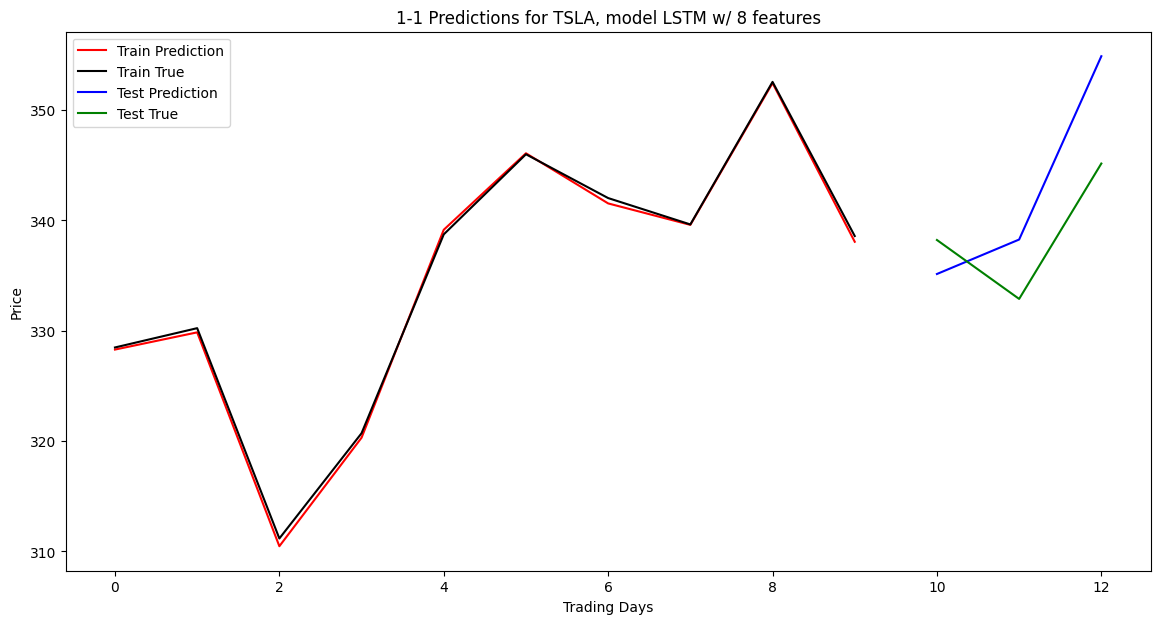

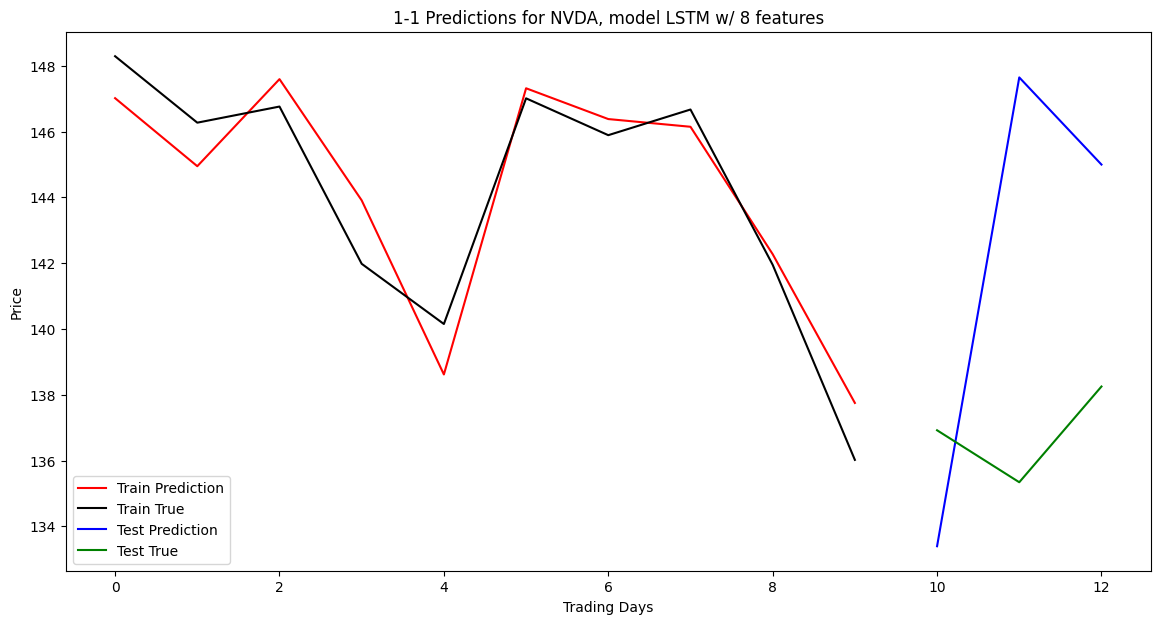

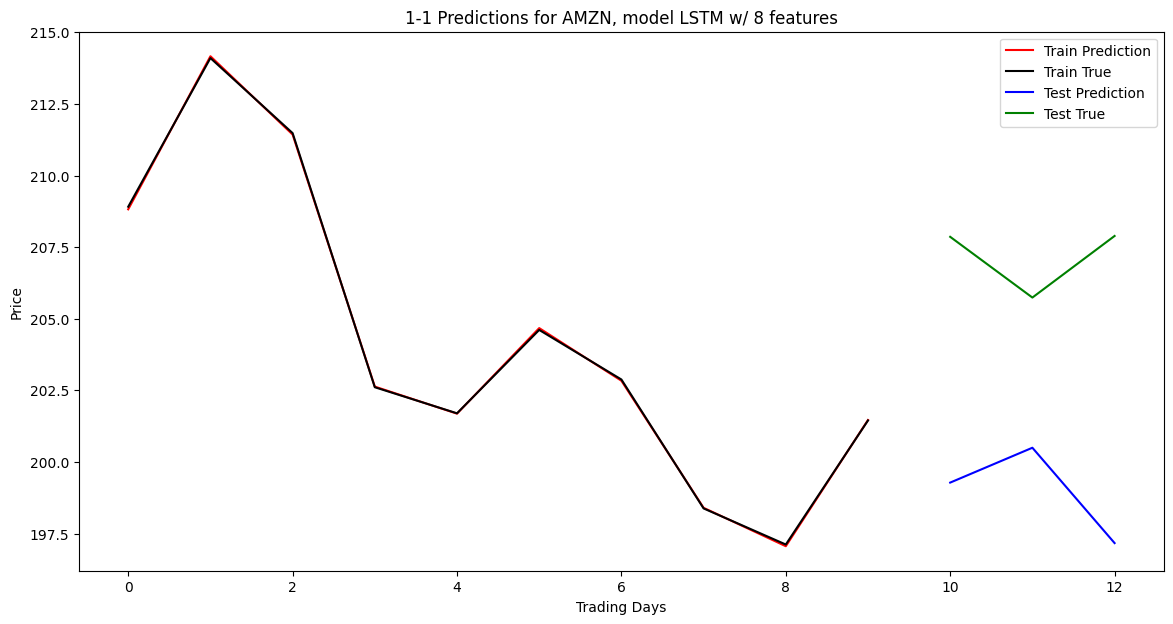

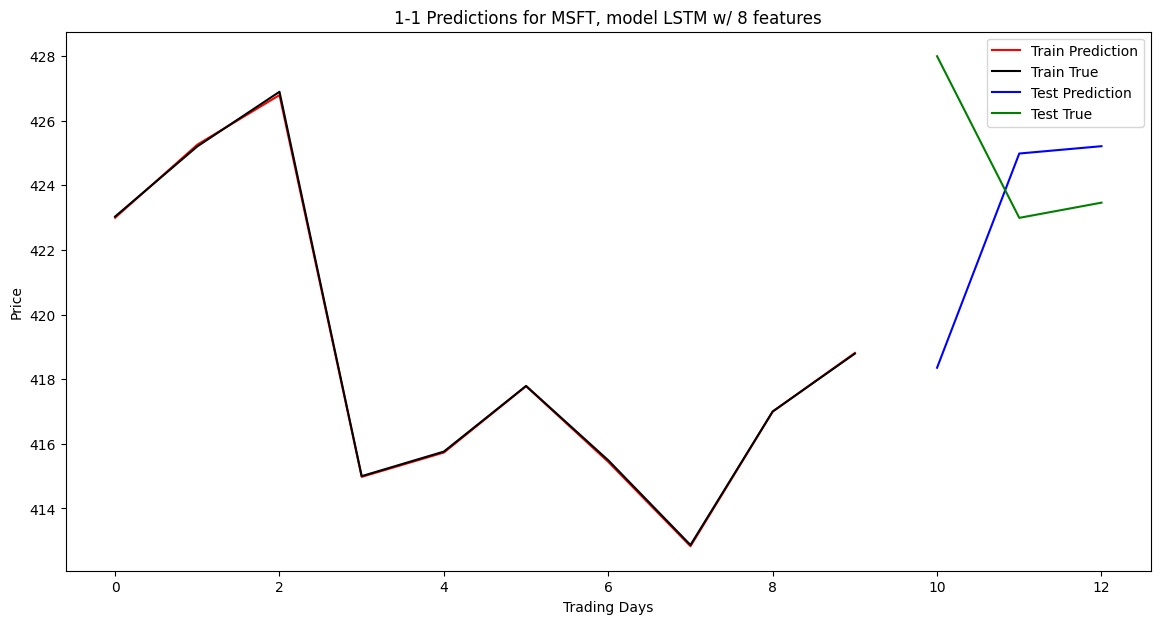

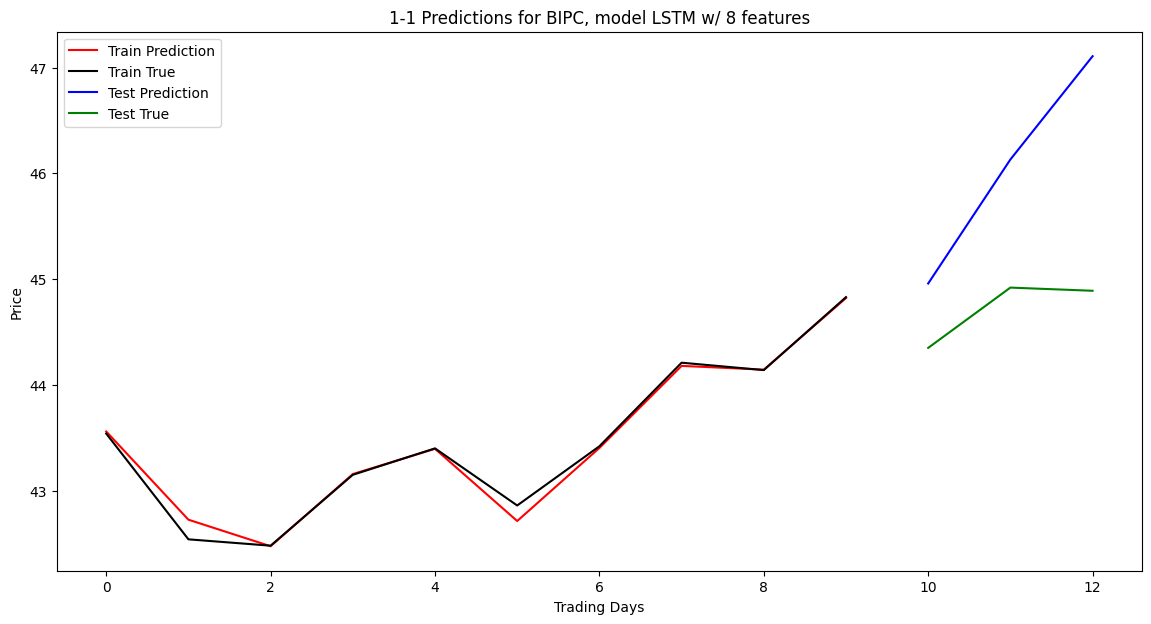

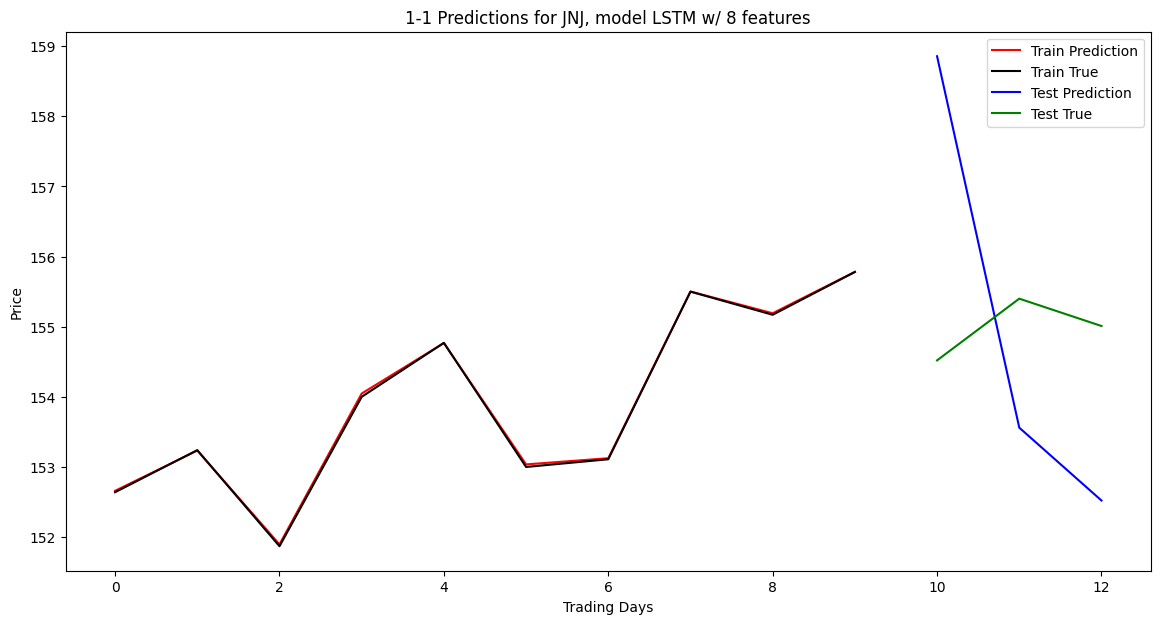

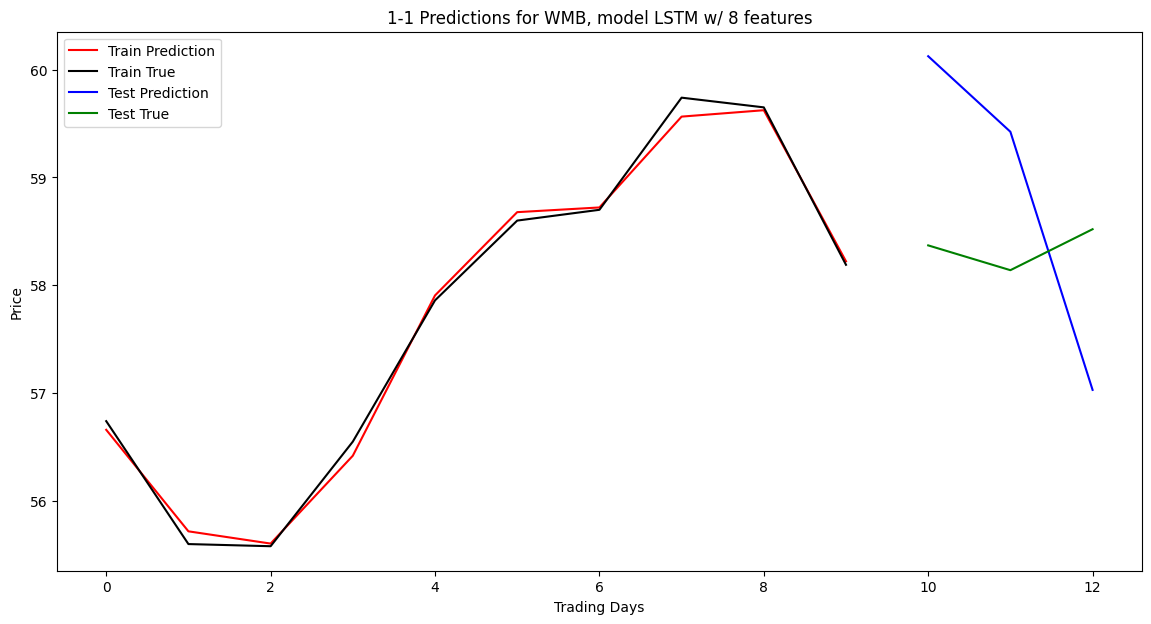

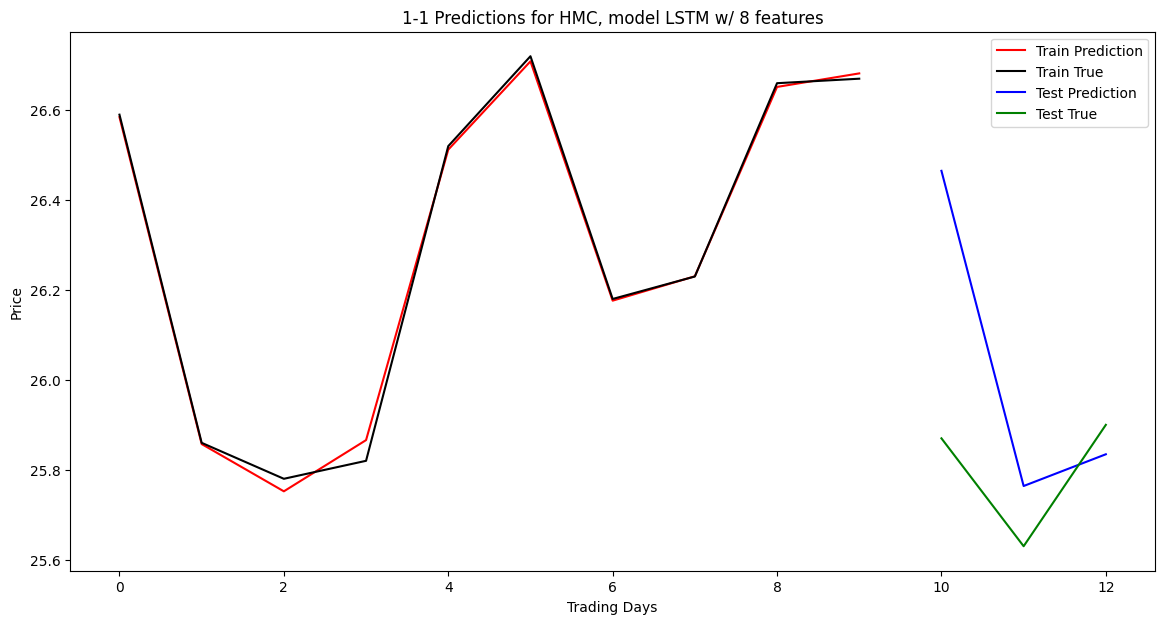

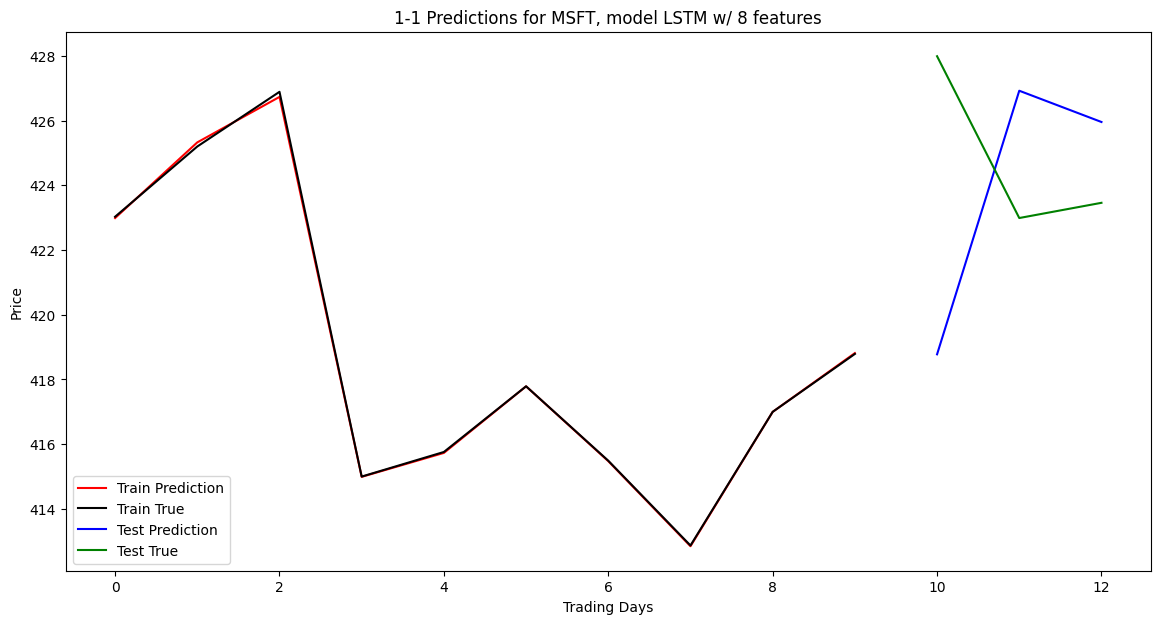

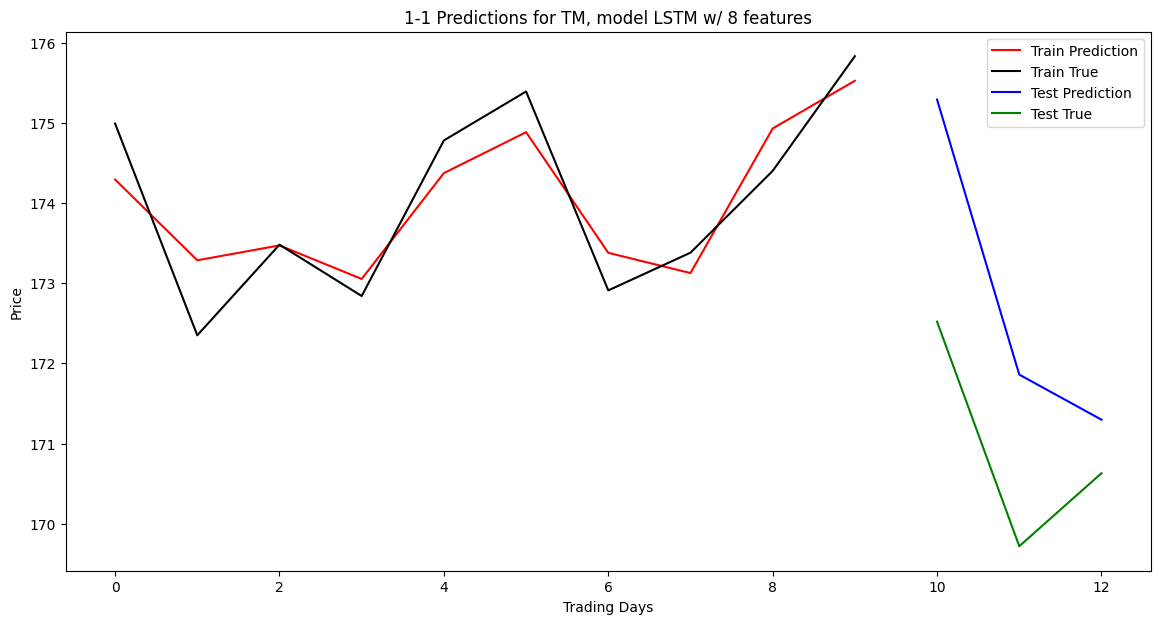

In [2]:
tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"]
mse = main(tickers)

In [3]:
mse

2.3107153982875754